## Auftrieb umströmter Körper

In diesem Kapitel werden wir sehen, dass auf einen Körper nur dann eine Auftriebskraft wirkt, wenn die Zirkulation $\Gamma$ - das Linienintegral des Geschwindigkeitsfeldes - auf einer beliebigen geschlossenen Kurve um den Körper ungleich Null ist.

### Satz von Kutta-Joukowski

Der aus der Strömungslehre bekannte Satz von [Kutta-Joukowski](https://de.wikipedia.org/wiki/Satz_von_Kutta-Joukowski) beschreibt für stationäre, reibungsfreie, drehungsfreie, inkompressible und zweidimensionale Strömungen den Zusammenhang zwischen der Zirkulation von $\overrightarrow{v}$ längst der Kurve $C$ und der Auftriebskraft (pro Tiefeneinheit):

$$\frac{F_A}{1~\text{m}} = \rho_\infty \cdot v_\infty \cdot \Gamma = \rho_\infty \cdot v_\infty \cdot \oint_C {\overrightarrow{v}(\overrightarrow{r}) \text{d} \overrightarrow{r}}$$

Es kommt also nur dann zu einer Auftriebskraft, wenn die Zirkulation einen positiven Wert annimmt. Dies ist der Fall, wenn die Strömung durch den umströmten Körper umgelenkt wird. Im reibungsfreien Fall ist dies eigentlich nicht möglich, da durch die fehlende Reibung kein "Anhaften" der Strömung an der Oberfläche erfolgt. Die Umströmung eines Schaufelprofils würde im Falle fehlender Reibungskräfte (bzw. sehr hoher Reynoldszahlen $\text{Re} = \frac{\text{Impulskräfte}}{\text{Reibungskräfte}} = \frac{v_\infty \cdot l \cdot \rho}{\mu}$) wie im folgenden Bild dargestellt aussehen. Auf das Profil würde keine Auftriebskraft wirken.

![](profilumstroemung_ohne_reibung.png)

Wenn mit der Potentialtheorie der Auftrieb simuliert werden soll, muss also eine Elementarströmung hinzugefügt werden, bei der die Zirkulation ungleich Null ist. Die einzige die hier in Frage kommt ist der Potentialwirbel.

### Der Magnus-Effekt

Um den Satz von Kutta-Joukowski bzw. den Effekt der Zirkulation anschaulich zu zeigen, eignet sich der [Magnus-Effekt](https://de.wikipedia.org/wiki/Magnus-Effekt). Dieser beschreibt die Kraft auf einen quer angeströmten, rotierenden Zylinder.

Technisch interessant ist der Magnus-Effekt z.B. für Schiffsantriebe ([Flettner-Rotor](https://de.wikipedia.org/wiki/Flettner-Rotor)), Vertikal-Windkraftanlagen, aber auch für die Realisierung einer Bananen-Flanke im Fußball. Sogar Flugzeuge wurden mit Flettner-Rotoren statt Tragflügel gebaut.

![](https://upload.wikimedia.org/wikipedia/commons/3/3f/Buckau_Flettner_Rotor_Ship_LOC_37764u.jpg)

Die Umströmung eines nicht-rotierenden Zylinders haben wir im vorangegangenen Kapitel bereits kennengelernt. Sie ergab sich aus der Überlagerung einer Dipolströmung mit einer Translationsströmung. Um den Magnus-Effekt zu simulieren müssen wir jetzt nur noch einen Potentialwirbel überlagern.

Wir kopieren also zunächst den bereits entwickelten Quellcode für die drei Elementarströmungen:

In [2]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

nx = 400                              # Anzahl der Punkte in x-Richtung
ny = 200                              # Anzahl der Punkte in y-Richtung
x = np.linspace(-10, 10, nx)          # 1D-Array mit x-Koordinaten
y = np.linspace(-5,  5, ny)           # 1D-Array mit y-Koordinaten

X, Y = np.meshgrid(x, y)              # erzeugt das Gitter mit nx * ny Punkten

def trans_v(x, y, u1, v1):            # Geschwindigkeitsvek. der Translationsstr.
    return np.full_like(x, u1), np.full_like(y, v1)

def trans_psi(x, y, u1, v1):          # Stromfunkt. der Translationsstr.
    return -v1*x+u1*y 
        
def trans_phi(x, y, u1, v1):          # Potentialfunkt. der Translationsstr.
    return u1*x+v1*y

def dipolx_v(x, y, xs, ys, M):        # Geschwindigkeitsvek. der Quellenstr.
    s = -M/(2*math.pi) / ((x-xs)**2+(y-ys)**2)**2
    return s*((x-xs)**2-(y-ys)**2), s*2*(x-xs)*(y-ys)

def dipolx_psi(x, y, xs, ys, M):      # Stromfunktion der Quellenströmung
    return -M/(2*math.pi) * (y-ys) / ((x-xs)**2+(y-ys)**2)
        
def dipolx_phi(x, y, xs, ys, M):      # Potentialfunktion der Quellenströmung
    return M/(2*math.pi) * (x-xs) / ((x-xs)**2+(y-ys)**2)

def vortex_v(x, y, x1, y1, Gamma):   # Geschwindigkeitsvek. des Potentialwirbels
    s = Gamma/(2*math.pi*((x-x1)**2+(y-y1)**2))
    return s*(y-y1), -s*(x-x1)

def vortex_psi(x, y, x1, y1, Gamma): # Stromfunktion des Potentialwirbels
    s = -Gamma/(2*math.pi)
    return -s*np.log(np.sqrt((x-x1)**2+(y-y1)**2))
        
def vortex_phi(x, y, x1, y1, Gamma): # Potentialfunktion des Potentialwirbels
    s = -Gamma/(2*math.pi)
    return np.arctan2((y-y1),(x-x1))

Soweit nichts Neues. Fehlt nur noch die lineare Überlagerung. 

Wir wählen eine Anströmgeschwindigkeit von $u_\infty = 1~\text{m/s}$, ein Dipolmoment $M = 30~\text{m}^3/\text{s}$ und eine Zirkulation $\Gamma = 10~ \text{m}^3/\text{s}$. 

In [15]:
u1 = 1.0
M = 30.0
Gamma = 20

u_trans, v_trans = trans_v(X, Y, u1, 0)          # Translationsströmung
u_dipol, v_dipol = dipolx_v(X, Y, 0, 0, M)       # Dipolströmung
u_vortex, v_vortex = vortex_v(X, Y, 0, 0, Gamma) # Potentialwirbel
u_gesamt = u_trans + u_dipol + u_vortex          # lineare Überlagerung
v_gesamt = v_trans + v_dipol + v_vortex

Die Darstellung der Stromlinien ergibt dann folgendes Bild:

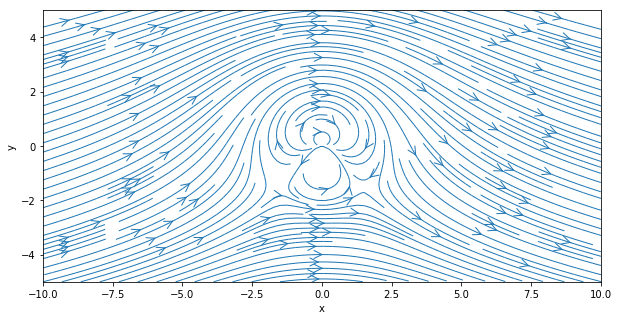

In [16]:
# Neuen Plot einrichten
plt.figure(figsize=(10, 5))
plt.xlabel('x')
plt.ylabel('y')
plt.xlim(-10,10)
plt.ylim(-5,5)

# Stromlinien mit Matplotlib-Funktion darstellen
plt.streamplot(X, Y, u_gesamt, v_gesamt, 
                  density=2, linewidth=1, arrowsize=2, arrowstyle='->');

Man sieht deutlich, dass die Strömung jetzt durch die Überlagerung des Potentialwirbels umgelenkt wird. Die Form des Zylinders ist in etwa erkennbar. Aber welchen Radius hat der Zylinder und welche Druckverteilung herrscht auf der Oberfläche des Zylinders?

Um den Radius zu ermitteln, benotigen wir die Koordinaten eines Staupunkts auf dem Zylinder. Da sich der Durchmesser durch den Potentialwirbel nicht ändert, können wir zunächst nur die Überlagerung aus Translations- und Dipolströmung betrachten:

$$u(x,y) = u_1 - \frac{M}{2\pi}\frac{x^2-y^2}{\left(x^2-y^2\right)^2} \stackrel{!}{=} 0$$

$$v(x,y) = 0 - \frac{M}{2\pi}\frac{2xy}{\left(x^2-y^2\right)^2} \stackrel{!}{=} 0$$

oder in Polarkoordinaten (vgl. Formelsammlung Potentialströmungen), weil eleganter:

$$u(r,\varphi) = u_1 - \frac{M}{2\pi}\frac{\cos(2\varphi)}{r^2} \stackrel{!}{=} 0$$

$$v(r,\varphi) = 0 - \frac{M}{2\pi}\frac{\sin(2\varphi)}{r^2} \stackrel{!}{=} 0$$

Die zweite Gleichung ist erfüllt, wenn $\varphi$ Vielfache von $\frac{1}{2}\pi$ annimmt. Setzen wir z.B. $\varphi = \pi$ in die vorletzte Gleichung ein, erhalten wir für den Radius des Zylinders:

$$R = \pm \sqrt{\frac{M}{2\pi\cdot u_1}}$$

Mit dieser Lösung für den Radius suchen wir nun die Winkel $\varphi$, unter denen die Staupunkte zu finden sind. Dazu benötigen wir die Überlagerung aller drei Elementarströmungen:

$$u(r,\varphi) = u_1 - \frac{M}{2\pi}\frac{\cos(2\varphi)}{r^2}+\frac{\Gamma}{2\pi}\frac{\sin(\varphi)}{r} \stackrel{!}{=} 0$$

$$v(r,\varphi) = 0 - \frac{M}{2\pi}\frac{\sin(2\varphi)}{r^2} - \frac{\Gamma}{2\pi}\frac{\cos(\varphi)}{r} \stackrel{!}{=} 0$$

Die Lösung für $r$ eingesetzt ergibt:

$$u(\varphi) = u_1 - u_1 \cos(2\varphi) + \Gamma \sqrt{\frac{u_1}{2\pi M}} \sin\varphi \stackrel{!}{=} 0$$

$$v(\varphi) = -u_1 \sin(2\varphi) - \Gamma \sqrt{\frac{u_1}{2\pi M}} \cos\varphi \stackrel{!}{=} 0$$

Lösen der vorletzten Gleichung nach $\varphi$ und Einsetzen der Lösungen in die letzte Gleichung liefert die Winkel, unter denen beide Geschwindigkeitskomponenten auf dem Radius $R$ Null werden:

$$\varphi_1 = -\sin^{-1} \left(\sqrt{\frac{u_1}{2\pi M}}\frac{\Gamma}{2u_1}\right) \qquad\qquad \varphi_2 = \sin^{-1} \left(\sqrt{\frac{u_1}{2\pi M}}\frac{\Gamma}{2u_1}\right) + \pi$$


Wir können unser Bild von oben jetzt erweitern und den Zylinder sowie seine Staupunkte einzeichnen:

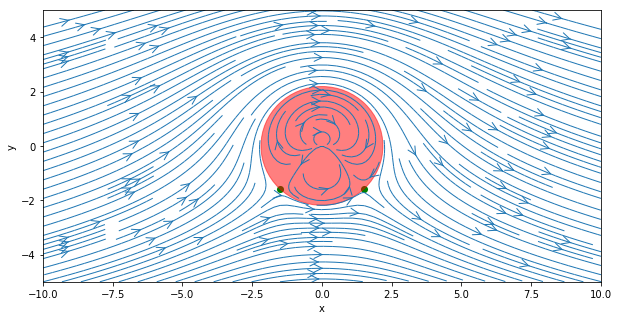

In [17]:
# Radius des Zylinders:
R = math.sqrt(M/(2*math.pi*u1))

# Staupunkte
phi1 = -math.asin(math.sqrt(u1/(2*math.pi*M))*Gamma/(2*u1))
phi2 = -phi1+math.pi
sx1 = R*math.cos(phi1)
sy1 = R*math.sin(phi1)
sx2 = R*math.cos(phi2)
sy2 = R*math.sin(phi2)

# Neuen Plot einrichten
plt.figure(figsize=(10, 5))
plt.xlabel('x')
plt.ylabel('y')
plt.xlim(-10,10)
plt.ylim(-5,5)

# Stromlinien mit Matplotlib-Funktion darstellen
plt.streamplot(X, Y, u_gesamt, v_gesamt, 
               density=2, linewidth=1, arrowsize=2, 
               arrowstyle='->');

# Zylinder einzeichnen
zylinder = plt.Circle((0,0),R,color='r', alpha=0.5)
plt.gcf().gca().add_artist(zylinder)

# Staupunkte einzeichnen
plt.scatter([sx1,sx2], [sy1,sy2], color='green', 
            s=50, marker='o', linewidth=0);

Die Druckverteilung auf der Oberfläche erhalten wir durch Einsetzen des Geschwindigkeitsverlaufs auf der Trennstromlinie in die Bernoulli-Gleichung, wie im vorletzten Kapitel gezeigt. 

$$p(\varphi) + \frac{\rho}{2} \cdot \left( u^2(\varphi)+v^2(\varphi) \right) = p_\infty + \frac{\rho}{2}\cdot \overrightarrow{v}_\infty^2 = const.$$

Die Gleichungen für $u(\varphi)$ und $v(\varphi)$ für $r=R$ haben wir oben schon hergeleitet, so dass wir die Druckverteilung einfach ausrechnen und plotten können: 

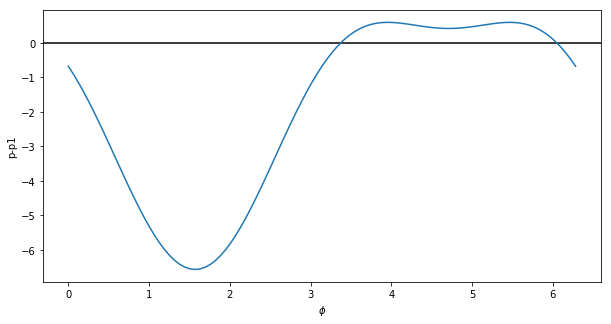

In [18]:
p1 = 102300
rho1 = 1.2

def v_zylinder(phi, u1, Gamma, M):
    u = (u1 
         - u1 * np.cos(2*phi)
         +Gamma*math.sqrt(u1/(2*math.pi*M))*np.sin(phi))
    v = (-u1*np.sin(2*phi)
         -Gamma*math.sqrt(u1/(2*math.pi*M))*np.cos(phi))
    return u,v

def p_zylinder(phi, u1, Gamma, M, p1, rho1):
    u,v = v_zylinder(phi, u1, Gamma, M)
    v_abs = np.sqrt(u**2+v**2)
    p = p1 + 0.5 * rho1 * (u1**2 - v_abs**2)
    return p

phi = np.linspace(0, 2*math.pi, 101)
p = p_zylinder(phi, u1, Gamma, M, p1, rho1)

# Neuen Plot einrichten
plt.figure(figsize=(10, 5))
plt.ylabel('p-p1')
plt.xlabel('$\phi$')
plt.axhline(0, color='black')

plt.plot(phi, p-p1);

Und siehe da, die Druckverteilung ist nicht mehr symmetrisch. D.h. es wirkt jetzt eine Kraft auf den Körper. Da die Druckkraft immer senkrecht auf die Oberfläche des Zylinders wirkt, können wir die $x$- und $y$-Komponente der Kraft wie folgt ausdrücken:

$$F_x = -\int_0^{2\pi} p(\varphi)~R~\cos\varphi ~d\varphi$$

$$F_y = -\int_0^{2\pi} p(\varphi)~R~\sin\varphi ~d\varphi$$

In [19]:
from scipy import integrate

def dFx(phi, u1, Gamma, M, p1, rho1, R):
    return -p_zylinder(phi, u1, Gamma, M, p1, rho1) * R * np.cos(phi)

def dFy(phi, u1, Gamma, M, p1, rho1, R):
    return -p_zylinder(phi, u1, Gamma, M, p1, rho1) * R * np.sin(phi)


F_x, err = integrate.quad(dFx, 0, 2*math.pi, args=(u1,Gamma,M,p1,rho1,R))
F_y, err = integrate.quad(dFy, 0, 2*math.pi, args=(u1,Gamma,M,p1,rho1,R))

print ('Widerstandskraft in x-Richtung: {0:7.2f}'.format(F_x))
print ('  Auftriebskraft in y-Richtung: {0:7.2f}'.format(F_y))

Widerstandskraft in x-Richtung:    0.00
  Auftriebskraft in y-Richtung:   24.00


Wie erwartet ist die berechnete Widerstandskraft gleich Null, da wir die Reibungskräfte mit der Potentialtheorie nicht berücksichtigen können.

Experimentieren Sie mit dem Wert für die Zirkulation. Für welchen Wert fallen die beiden Staupunkte zusammen?

[Hier](2_5-Potentialtheorie_Quell-Panel-Verfahren.ipynb) geht's weiter oder [hier](index.ipynb) zurück zur Übersicht.


---
###### Copyright (c) 2018, Florian Theobald und Matthias Stripf

Der folgende Python-Code darf ignoriert werden. Er dient nur dazu, die richtige Formatvorlage für die Jupyter-Notebooks zu laden.

In [7]:
from IPython.core.display import HTML
def css_styling():
    styles = open('TFDStyle.css', 'r').read()
    return HTML(styles)
css_styling()